In [1]:
from importlib import reload
import sys
sys.path.append("../src")
import brownian
import time_series
import acoustic_entrainment
reload(brownian)
reload(time_series)
reload(acoustic_entrainment)
from acoustic_entrainment import VelocityResponse, muflown_response, muflown_sensitivity, mic_response
from time_series import find_files, find_ders, Collection, bin_func, TimeSeries
from brownian import abc_guess, get_krhoA, psd_func, logbin_func
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

from os import path

from matplotlib import rc
fontsize = 7.5
fontstyle = {
    "pdf.fonttype": 42, # type 3 pdf fonts
    "mathtext.default": 'regular', # italic math
    "text.usetex": True, # latex-based math
    # sans-serif Helvetica font
    "text.latex.preamble":
        r'\usepackage{helvet} \usepackage{sansmath} \sansmath',
    "font.family": "sans-serif",
    # font sizes
    "axes.labelsize": fontsize,
    'axes.titlesize': fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    'xtick.direction': "inout",
    'xtick.top': True,
    'xtick.major.size': 4,
    'xtick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    "ytick.labelsize": fontsize,
    'ytick.direction': "inout",
    'ytick.right': True,
    'ytick.major.size': 4,
    'ytick.major.width': 0.5,
    'ytick.minor.width': 0.5,
    "axes.linewidth": 0.5,
}
plt.rcParams.update(fontstyle)

# New function definitions

In [2]:
def sort_fnames(fnames, include=None):
    """
    Sort file names of the form <path>/iter_i by the iteration index i. 
    Include files with aspecific iteration index by passing a list to include. 
    """
    iters = [int(fname.split("_")[-1].split(".tdms")[0]) for fname in fnames]
    fnames_sorted = [fname for _, fname in sorted(zip(iters, fnames))]
    iters = sorted(iters)
    if include is not None:
        fnames_sorted = [fname for fname, itr in zip(fnames_sorted, iters) if itr in include]
    return fnames_sorted

from constants import kB
from scipy.integrate import cumulative_trapezoid

reload(brownian)
reload(acoustic_entrainment)
reload(time_series)
from acoustic_entrainment import VelocityResponse
from time_series import Collection
from brownian import get_params_from_abcRT, abc_guess, logbin_func, psd_func

def psd_calibration(fname, channel="X",
                   fmin=5e2, fmax=4e4, cutoff=1e6,  taumax=100e-3,freq_xnoise2=2e5,
                   plot=False, ax=None, logbin_Npts=20, color="k", data_plot_kwargs={}, fit_plot_kwargs={}):
    if plot:
        if ax is None:
            fig, ax = plt.subplots(1,1, figsize=(6,4))
        else:
            fig = plt.gcf()
        #axins = inset_axes(ax, width="45%", height="40%", loc="lower left", borderpad=2.3)
    C = Collection(fname)
    C.set_collection(channel)
    Tavg = np.mean(C.T)
    if Tavg < 273.15:
        Tavg += 273.15
    Npts = int(C.r / (2*cutoff))
    C.apply("detrend", inplace=True, mode="constant")
    #C.apply("lowpass", cutoff=cutoff, order=3, inplace=True)
    C.apply("bin_average", Npts=Npts, inplace=True)
    freq, psd = C.average("PSD", window="hamming", taumax=taumax)
    mask = np.logical_and(freq>fmin, freq<fmax)
    abc, abc_cov = abc_guess(freq[mask], psd[mask], n=C.Navg_psd)
    cal_params = get_params_from_abcRT(*abc, C.R, Tavg)
    C.params.update(cal_params)
    psd *= C.cal**2
    xnoise2 = np.mean(psd[freq>freq_xnoise2])
    C.xnoise2 = xnoise2
    if plot:
        plot_freq  = logbin_func(freq, Npts=logbin_Npts)
        plot_psd  = logbin_func(psd, Npts=logbin_Npts)
        dplot_kwargs = dict(mec=color, mfc="none", marker="o", ls="none")
        dplot_kwargs.update(data_plot_kwargs)
        ax.loglog(plot_freq, plot_psd, **dplot_kwargs)
        
        fplot_kwargs = dict(c=color)
        fplot_kwargs.update(data_plot_kwargs)
        ax.loglog(freq, psd_func(freq, C.k, C.rho, C.Tavg, C.R)+xnoise2, **fplot_kwargs)
        #ax.axhline(xnoise2)
        #ax.axvline(fmin, c="k", lw=1)
        #ax.axvline(fmax, c="k", lw=1)
        #axins.plot(freq, psd, c=color, marker=".", ls="none")
        #axins.set_xlim(500, 7000)
        #axins.set_ylim(0.9e-20, 5.1e-20)
        ax.set_ylabel(r"PSD $\rm (m^2 Hz^{-1})$")
        ax.set_xlabel(r"Frequency (Hz)")
        ax.set_xlim(right=cutoff)
        ax.set_ylim(bottom=1e-25)
        return C, ax
    return C

def cPSD(freq, psd, initial=None):
    if initial is None:
        initial = psd[0]*(freq[1]-freq[0])
    return cumulative_trapezoid(psd, x=freq, initial=initial)

# Directory structure

In [3]:
# Data by date
base_der = "/data/brownian"
date_ders = find_ders(base_der)
date_ders

['/data/brownian/20211215',
 '/data/brownian/20220330',
 '/data/brownian/20220518',
 '/data/brownian/20220525',
 '/data/brownian/20220614',
 '/data/brownian/20220628',
 '/data/brownian/20220523']

In [4]:
# Select a date
date_der_index = 5
bead_ders = find_ders(date_ders[date_der_index])
bead_ders

['/data/brownian/20220628/bead1']

In [5]:
# Select a date
bead_der_index = 0
experiment_ders = find_ders(bead_ders[bead_der_index])
experiment_ders

['/data/brownian/20220628/bead1/slow-fast_baseline',
 '/data/brownian/20220628/bead1/slow-phone_pulses_ene-scan',
 '/data/brownian/20220628/bead1/slow-flown_pulses_ene-scan',
 '/data/brownian/20220628/bead1/slow-fast_pulses_ene-scan']

# Bead calibration

In [6]:
baseline_experiment_index = (0,)
baseline_fnames = find_files(experiment_ders[baseline_experiment_index[0]])
for experiment_der_index in baseline_experiment_index[1:]:
    baseline_fnames.append(find_files(experiment_ders[experiment_der_index]))

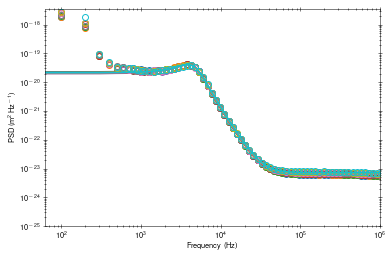

In [7]:
fmin = 6e2
fmax = 1e4
cutoff = 1000e3
taumax = 10e-3

fig, ax = plt.subplots(1,1, figsize=(6,4))

krhoCalTs = []
for fnamei, fname in enumerate(sort_fnames(baseline_fnames)):
    color = f"C{fnamei}"
    C0, ax = psd_calibration(fname, taumax=taumax, fmin=fmin, fmax=fmax, cutoff=cutoff, 
                             plot=True, ax=ax, color=color)
    krhoCalTs.append([C0.k, C0.rho, C0.cal, C0.Tavg])    
krhoCalTs = np.array(krhoCalTs)

k : 20.59403040815555 0.3847358936403961 1.8681913448473633
rho : 1468.008128089742 30.484794968360998 2.0766094127850363
cal : 5.147398011685639 0.2137051026192339 4.151711255552415
T : 22.863138811177482 0.00740583165268301 0.03239201630994953


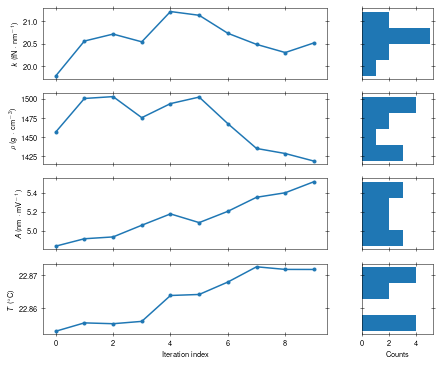

In [8]:
fig, axs = plt.subplots(4,2, figsize=(7, 6), gridspec_kw={"width_ratios":[0.8, 0.2]}, sharey="row", sharex="col")

ylabels = [r"$k~{\rm (fN \cdot nm^{-1})}$", r"$\rho~{\rm (g \cdot cm^{-3})}$", r"$A~{\rm (nm \cdot mV^{-1})}$", r"$T~{\rm (^{\circ}C)}$"]

for parami, param in enumerate(["k", "rho", "cal", "T"]):
    vals = krhoCalTs[:, parami]
    # units
    if param == "k":
        vals = vals * 1e15 / 1e9
    if param =="cal":
        vals = vals * 1e9/1e3
    if param == "T":
        vals = vals -273.15
    # plot data
    axs[parami, 0].plot(vals, marker=".")
    axs[parami, 1].hist(vals, bins=4, orientation="horizontal")
    # labels
    axs[parami, 0].set_ylabel(ylabels[parami])
    axs[3, 0].set_xlabel("Iteration index")
    axs[3, 1].set_xlabel("Counts")
    print(param, ":", np.mean(vals), np.std(vals), 100*np.std(vals)/np.mean(vals))
k, rho, cal, _ = np.mean(krhoCalTs, axis=0)
R = C0.R

# Pulsed laser energy scan

In [9]:
experiment_ders

['/data/brownian/20220628/bead1/slow-fast_baseline',
 '/data/brownian/20220628/bead1/slow-phone_pulses_ene-scan',
 '/data/brownian/20220628/bead1/slow-flown_pulses_ene-scan',
 '/data/brownian/20220628/bead1/slow-fast_pulses_ene-scan']

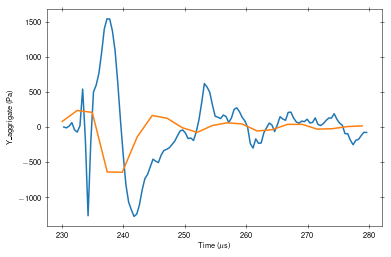

In [10]:
fnames = find_files(experiment_ders[1])
bd_cutoff = 1000e3
ph_cutoff = 200e3
tmin= 230e-6
tmax = 280e-6
fig, ax = plt.subplots(1,1)
for fname in sort_fnames(fnames)[-1:]:
    Cbd = Collection(fname)
    T = np.mean(Cbd.T)
    RH = C0.cRH
    VR = VelocityResponse(-1/cal, R, rho, T, RH, k)
    response = lambda f:VR.response("bassetbound", f)/VR.plane_impedance(f, r0=1)

    Cbd.set_collection("X")
    Cbd.apply("bin_average", Npts=int(Cbd.r/(2*bd_cutoff)), inplace=True)
    Cbd.apply("correct", response=response, n_jobs=1, window="boxcar", differentiate=True, recollect=True)
    Cbd.apply("detrend", mode="constant", inplace=True)
    Cbd.aggrigate()
    Cbd.agg.plot(ax=ax, tmin=tmin, tmax=tmax, unit="Pa", tunit="us")
    #Cbd.collection[15].plot(ax=ax, tmin=tmin, tmax=tmax, unit="Pa", tunit="us")

    Cph = Collection(fname)
    Cph.set_collection("Y")
    Cph.apply("bin_average", Npts=int(Cph.r/(2*ph_cutoff)), inplace=True)
    Cph.apply("correct", response=mic_response, n_jobs=1, window="boxcar", recollect=True)
    Cph.apply("shift", tau=20e-6, inplace=True)
    Cph.aggrigate()

    Cph.agg.plot(ax=ax, tmin=tmin, tmax=tmax, unit="Pa", tunit="us")
    #Cph.collection[20].plot(ax=ax, tmin=tmin, tmax=tmax, unit="Pa", tunit="us")



In [70]:
def make_musphere_response(C0, impedance=None, r0=3e-2, response="bassetbound"):
    T = np.mean(C0.T)
    RH = C0.cRH
    VR = VelocityResponse(1/C0.cal, C0.R, C0.rho, T, RH, C0.k)
    if impedance is None:
        _response = lambda f:VR.response(response, f)
    else:
        print("enter")
        impedance = getattr(VR, f"{impedance}_impedance")
        _response = lambda f:VR.response(response, f)/impedance(f, r0)
    return _response

def load_collection(fname, channel, response, differentiate, cutoff=1e6, shift=0, invert=False, window="boxcar"):
    C = Collection(fname)
    C.set_collection(channel)
    #C.apply("lowpass", cutoff=cutoff/2, inplace=True)
    C.apply("bin_average", Npts=int(C.r/(2*cutoff)), inplace=True)
    C.apply("detrend", mode="linear", inplace=True)
    if response is not None:
        C.apply("correct", response=response, n_jobs=1, 
            window=window, differentiate=differentiate, recollect=True)
    if response is None and differentiate:
        C.apply("differentiate", inplace=True)
    C.apply("shift", tau=shift, inplace=True)
    if invert:
        C.apply("calibrate", cal=-1, inplace=True)
    C.aggrigate()
    return C

In [71]:
def deg2rad(x):
    return x * np.pi / 180


def rad2deg(x):
    return x * 180 / np.pi

def radian_labels(ax, denoms=[-1, -2, 0, 2, 1], skip=1):
    rads = [np.pi/d if d!=0 else 0 for d in denoms]
    rad_labels = [r"$-\pi/%s$" % abs(d) if d<-1 \
             else r"$\pi/%s$" % abs(d) if d>1 \
             else "$-\pi$" if d == -1 \
             else "$\pi$" if d == 1 \
             else "$0$" for d in denoms]
    return rads, rad_labels
    

def dB_re(x, ref, typ):
    if typ == "pressure":
        deci = 20.
    elif typ == "power":
        deci = 10.
    return deci * np.log10(x/ref)

def db_re_inverse(x, ref, typ):
    if typ == "pressure":
        deci = 20.
    elif typ == "power":
        deci = 10.
    return ref * 10**(x/deci)


def SPL(x):
    return dB_re(x, ref=20e-6, typ="pressure")

def todB(x):
    return dB_re(x, ref, typ)


Text(0.5, 0, 'Frequency (Hz)')

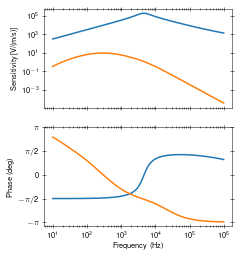

In [13]:
fig, axs = plt.subplots(2,1, figsize=(3.37, 4), sharex=True)
musphere_response = make_musphere_response(C0, response="bassetbound", impedance=None)





fs = np.geomspace(10, 1e6, 100)
axs[0].loglog(fs, np.abs(musphere_response(fs)))
axs[0].loglog(fs, np.abs(muflown_response(fs)))
axs[1].semilogx(fs, np.angle(musphere_response(fs)))
axs[1].semilogx(fs, np.angle(muflown_response(fs)))

axs[0].set_ylabel("Sensitivity [V/(m/s)]")

rads, rad_labels = radian_labels(ax, denoms=[-1, -2, 0, 2, 1], skip=1)
axs[1].set_yticks(rads)
axs[1].set_yticklabels(rad_labels)
#secax1 = axs[1].secondary_yaxis('right', functions=(rad2deg, deg2rad))
#secax1.set_yticks([-180, -90, 0, 90, 180])
axs[1].set_ylabel("Phase (rad)")
axs[1].set_ylabel("Phase (deg)")
axs[1].set_xlabel("Frequency (Hz)")

enter


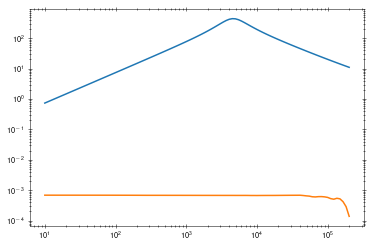

In [14]:
musphere_response = make_musphere_response(C0, impedance="plane")
fs = np.geomspace(10, 200e3, 100)
plt.loglog(fs, np.abs(musphere_response(fs)))
plt.loglog(fs, np.abs(mic_response(fs)))

enter


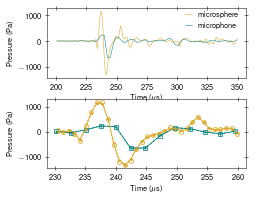

In [15]:
bd_color = "goldenrod"
ph_color = "teal"
tmin0 = 200e-6
tmax0 = 350e-6
tmin= 230e-6
tmax = 260e-6

fnames = sort_fnames(find_files(experiment_ders[1]))[-1]

musphere_response = make_musphere_response(C0, response="bassetbound", impedance="cyl", r0=1e-3)

Cbd = load_collection(fname, "X", musphere_response, 
                      differentiate=True, cutoff=500e3, shift=0, invert=True)
Cph = load_collection(fname, "Y", mic_response, 
                      differentiate=False, cutoff=200e3, shift=15e-6, invert=False)

fig, axs = plt.subplots(2,1, figsize=(3.375, 3))
Cbd.agg.plot(ax=axs[0], tmin=tmin0, tmax=tmax0, unit="Pa", tunit="us", c=bd_color, lw=0.5, label="microsphere")
Cph.agg.plot(ax=axs[0], tmin=tmin0, tmax=tmax0, unit="Pa", tunit="us", c=ph_color, lw=0.5, label="microphone")

Cbd.agg.plot(ax=axs[1], tmin=tmin, tmax=tmax, unit=1, tunit="us",
             marker="o", ms=1.5, c=bd_color, lw=0.75, zorder=10)
Cbd.collection[20].plot(ax=axs[1], tmin=tmin, tmax=tmax, unit="Pa", tunit="us",
              marker="o", ms=4, c=bd_color, mec=bd_color, mfc="none", ls="--", lw=0.75, mew=0.75)

Cph.agg.plot(ax=axs[1], tmin=tmin, tmax=tmax, unit="Pa", tunit="us",
              marker="s", ms=1, c=ph_color, lw=0.75)
Cph.collection[20].plot(ax=axs[1], tmin=tmin, tmax=tmax, unit="Pa", tunit="us",
                       marker="s", ms=4, c=ph_color, mec=ph_color, mfc="none", ls="--", lw=0.75, mew=0.75)

plt.subplots_adjust(hspace=0.3, left=0.16, right=0.98, top=0.9, bottom=0.16)
for ax in axs:
    #ax.set_yticks((-1500, -1000, -500, 0, 500, 1000, 1500))
    #ax.set_yticklabels(("", -1000, "", 0, "", 1000, ""))
    ax.set_ylabel("Pressure (Pa)")
axs[0].legend(handlelength=1, frameon=False, loc="upper right", bbox_to_anchor=(1,1.05))
plt.savefig("figures/pulsed_laser_bead-mic.pdf")

In [16]:
fnames_ph = sort_fnames(find_files(experiment_ders[1]))
fnames_fl = sort_fnames(find_files(experiment_ders[2]))
fnames_bdf = sort_fnames(find_files(experiment_ders[3]))

In [17]:
fnames_bdf

['/data/brownian/20220628/bead1/slow-fast_pulses_ene-scan/iter_0.tdms',
 '/data/brownian/20220628/bead1/slow-fast_pulses_ene-scan/iter_1.tdms',
 '/data/brownian/20220628/bead1/slow-fast_pulses_ene-scan/iter_2.tdms',
 '/data/brownian/20220628/bead1/slow-fast_pulses_ene-scan/iter_3.tdms',
 '/data/brownian/20220628/bead1/slow-fast_pulses_ene-scan/iter_4.tdms']

enter


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Time ($\\rm \\mu s$)', ylabel='Y_aggrigate ($\\rm V$)'>)

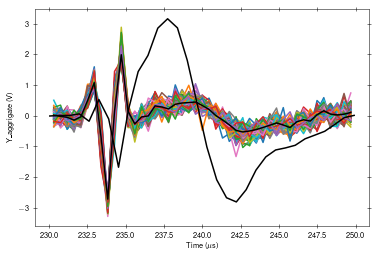

In [310]:
tmin = 230e-6
tmax=250e-6
fig, ax = plt.subplots(1,1)

cal = C0.cal
musphere_response_p = make_musphere_response(C0, response="bassetbound", impedance="plane")
musphere_response_u = make_musphere_response(C0, response="bassetbound", impedance=None)
C0.cal *= 4
musphere_fast_response_u = make_musphere_response(C0, response="exact", impedance=None)
C0.cal = cal

Cbd_bdf = load_collection(fnames_bdf[3], "X", musphere_response_u, 
                      differentiate=True, cutoff=700e3, shift=0, invert=True)
Cbdf = load_collection(fnames_bdf[3], "Y", musphere_fast_response_u, 
                      differentiate=True, cutoff=1000e3, shift=0e-6, invert=True)

peaks = np.zeros((100, 2))
for Di, D in enumerate(Cbdf.collection[25:]):
    #D.x += i*4
    
    D.plot(ax=ax, tmin=tmin, tmax=tmax, unit="V", tunit="us")
    mask = np.logical_and(D.t>tmin, D.t<236e-6)
    peakdex = np.argmax(D.x[mask])
    peaks[Di] = [D.t[mask][peakdex], D.x[mask][peakdex]-i/2]

Cbd_bdf.agg.plot(ax=ax, tmin=tmin, tmax=tmax, c="k", unit="V", tunit="us")
Cbdf.agg.plot(ax=ax, tmin=tmin, tmax=tmax, c="k", unit="V", tunit="us")

In [265]:
376*1e-5

0.0037600000000000003

(<Figure size 648x288 with 1 Axes>,
 <AxesSubplot:xlabel='Time ($\\rm \\mu s$)', ylabel='Y_aggrigate ($\\rm $)'>)

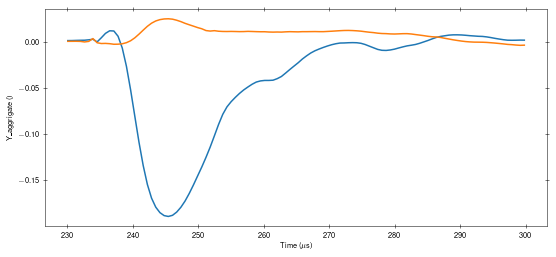

In [69]:
tmin = 230e-6
tmax=300e-6
Cbd_bdf = load_collection(fnames_bdf[-2], "X", None, 
                      differentiate=True, cutoff=700e3, shift=0, invert=True)
Cbdf = load_collection(fnames_bdf[-2], "Y", None, 
                      differentiate=True, cutoff=700e3, shift=0, invert=True)

fig, ax = Cbd_bdf.agg.plot(tmin=tmin, tmax=tmax, unit="V", tunit="us")
Cbdf.agg.plot(ax=ax, tmin=tmin, tmax=tmax, unit=1/4, tunit="us")

5.517152275481869e-06
enter
220.0 79.99999999999997 300.0


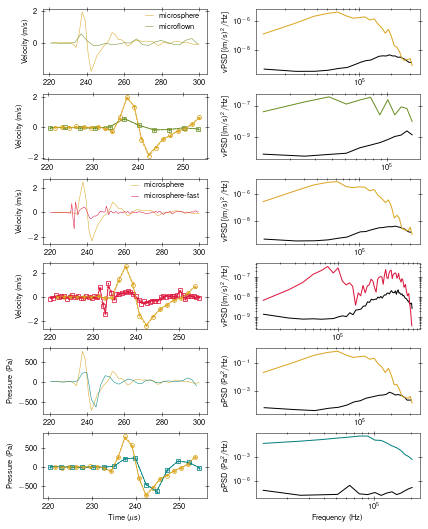

In [245]:
fl_color = "olivedrab"
bd_color = "goldenrod"
ph_color = "teal"
bdf_color = "crimson"
tmin0 = 220e-6
tmax0 = 300e-6

tmin= 220e-6
tmax = 255e-6
unit = 1

from copy import copy
print(C0.cal)
cal = C0.cal
musphere_response_p = make_musphere_response(C0, response="bassetbound", impedance="plane")
musphere_response_u = make_musphere_response(C0, response="bassetbound", impedance=None)
C0.cal *= 4
musphere_fast_response_u = make_musphere_response(C0, response="bassetbound", impedance=None)
C0.cal = cal


Cbd_ph = load_collection(fnames_ph[-2], "X", musphere_response_p, 
                      differentiate=True, cutoff=300e3, shift=0, invert=True)
Cph = load_collection(fnames_ph[-2], "Y", mic_response, 
                      differentiate=False, cutoff=200e3, shift=15e-6, invert=False)

Cbd_fl = load_collection(fnames_fl[-2], "X", musphere_response_u, 
                      differentiate=True, cutoff=300e3, shift=0, invert=True)
Cfl = load_collection(fnames_fl[-2], "Y", muflown_response, 
                      differentiate=False, cutoff=150e3, shift=27e-6, invert=False)

Cbd_bdf = load_collection(fnames_bdf[-2], "X", musphere_response_u, 
                      differentiate=True, cutoff=300e3, shift=0, invert=True)
Cbdf = load_collection(fnames_bdf[-2], "Y", musphere_fast_response_u, 
                      differentiate=True, cutoff=700e3, shift=1e-6, invert=False)


Dt = tmax0 - tmin

print(tmin*1e6, Dt*1e6, (tmin+Dt)*1e6)

fl0_freq, fl0_psd = Cfl.average("PSD", tmin=None, tmax=Dt, window="boxcar")
ph0_freq, ph0_psd = Cph.average("PSD", tmin=None, tmax=Dt, window="boxcar")
bdf0_freq, bdf0_psd = Cbdf.average("PSD", tmin=None, tmax=Dt, window="boxcar")

fl_freq, fl_psd = Cfl.average("PSD", tmin=tmin, tmax=tmin+Dt, window="boxcar")
ph_freq, ph_psd = Cph.average("PSD", tmin=tmin, tmax=tmin+Dt, window="boxcar")
bdf_freq, bdf_psd = Cbdf.average("PSD", tmin=tmin, tmax=tmin+Dt, window="boxcar")



fig, axs = plt.subplots(6,2, figsize=(2*3.375, 3*3))


Cbd = Cbd_fl
bd0_freq, bd0_psd = Cbd.average("PSD", tmin=None, tmax=Dt, window="boxcar")
bd_freq, bd_psd = Cbd.average("PSD", tmin=tmin, tmax=tmin+Dt, window="boxcar")

Cbd.agg.plot(ax=axs[0,0], tmin=tmin0, tmax=tmax0, unit=unit, tunit="us", c=bd_color, lw=0.5, label="microsphere")
Cfl.agg.plot(ax=axs[0,0], tmin=tmin0, tmax=tmax0, unit="m_s", tunit="us", c=fl_color, lw=0.5, label="microflown")

Cbd.agg.plot(ax=axs[1,0], tmin=tmin, tmax=tmax, unit=unit, tunit="us",
             marker="o", ms=1.5, c=bd_color, lw=0.75, zorder=10)
Cbd.collection[20].plot(ax=axs[1,0], tmin=tmin, tmax=tmax, unit=unit, tunit="us",
              marker="o", ms=4, c=bd_color, mec=bd_color, mfc="none", ls="--", lw=0.75, mew=0.75)

Cfl.agg.plot(ax=axs[1,0], tmin=tmin, tmax=tmax, unit="m_s", tunit="us",
              marker="s", ms=1, c=fl_color, lw=0.75)
Cfl.collection[20].plot(ax=axs[1,0], tmin=tmin, tmax=tmax, unit="m_s", tunit="us",
                       marker="s", ms=4, c=fl_color, mec=fl_color, mfc="none", ls="--", lw=0.75, mew=0.75)

axs[0,1].loglog(bd0_freq[1:], bd0_psd[1:]/unit**2, c="k", lw=1)
axs[0,1].loglog(bd_freq[1:],  bd_psd[1:]/unit**2, c=bd_color, lw=1)

axs[1,1].loglog(fl0_freq[1:], fl0_psd[1:], c="k", lw=1)
axs[1,1].loglog(fl_freq[1:], fl_psd[1:], c=fl_color, lw=1)





Cbd = Cbd_bdf
bd0_freq, bd0_psd = Cbd.average("PSD", tmin=None, tmax=Dt, window="boxcar")
bd_freq, bd_psd = Cbd.average("PSD", tmin=tmin, tmax=tmin+Dt, window="boxcar")


Cbd.agg.plot(ax=axs[2,0], tmin=tmin0, tmax=tmax0, unit=unit, tunit="us", c=bd_color, lw=0.5, label="microsphere")
Cbdf.agg.plot(ax=axs[2,0], tmin=tmin0, tmax=tmax0, unit="m_s", tunit="us", c=bdf_color, lw=0.5, label="microsphere-fast")

Cbd.agg.plot(ax=axs[3,0], tmin=tmin, tmax=tmax, unit=unit, tunit="us",
             marker="o", ms=1.5, c=bd_color, lw=0.75, zorder=10)
Cbd.collection[20].plot(ax=axs[3,0], tmin=tmin, tmax=tmax, unit=unit, tunit="us",
              marker="o", ms=4, c=bd_color, mec=bd_color, mfc="none", ls="--", lw=0.75, mew=0.75)

Cbdf.agg.plot(ax=axs[3,0], tmin=tmin, tmax=tmax, unit="m_s", tunit="us",
              marker="s", ms=1, c=bdf_color, lw=0.75)
Cbdf.collection[20].plot(ax=axs[3,0], tmin=tmin, tmax=tmax, unit="m_s", tunit="us",
                       marker="s", ms=4, c=bdf_color, mec=bdf_color, mfc="none", ls="--", lw=0.75, mew=0.75)

axs[2,1].loglog(bd0_freq[1:], bd0_psd[1:]/unit**2, c="k", lw=1)
axs[2,1].loglog(bd_freq[1:],  bd_psd[1:]/unit**2, c=bd_color, lw=1)

axs[3,1].loglog(bdf0_freq[1:], bdf0_psd[1:], c="k", lw=1)
axs[3,1].loglog(bdf_freq[1:], bdf_psd[1:], c=bdf_color, lw=1)





Cbd = Cbd_ph
bd0_freq, bd0_psd = Cbd.average("PSD", tmin=None, tmax=Dt, window="boxcar")
bd_freq, bd_psd = Cbd.average("PSD", tmin=tmin, tmax=tmin+Dt, window="boxcar")

Cbd.agg.plot(ax=axs[4,0], tmin=tmin0, tmax=tmax0, unit=unit, tunit="us", c=bd_color, lw=0.5, label="microsphere")
Cph.agg.plot(ax=axs[4,0], tmin=tmin0, tmax=tmax0, unit="m_s", tunit="us", c=ph_color, lw=0.5, label="microphone")

Cbd.agg.plot(ax=axs[5,0], tmin=tmin, tmax=tmax, unit=unit, tunit="us",
             marker="o", ms=1.5, c=bd_color, lw=0.75, zorder=10)
Cbd.collection[20].plot(ax=axs[5,0], tmin=tmin, tmax=tmax, unit=unit, tunit="us",
              marker="o", ms=4, c=bd_color, mec=bd_color, mfc="none", ls="--", lw=0.75, mew=0.75)

Cph.agg.plot(ax=axs[5,0], tmin=tmin, tmax=tmax, unit="m_s", tunit="us",
              marker="s", ms=1, c=ph_color, lw=0.75)
Cph.collection[20].plot(ax=axs[5,0], tmin=tmin, tmax=tmax, unit="m_s", tunit="us",
                       marker="s", ms=4, c=ph_color, mec=ph_color, mfc="none", ls="--", lw=0.75, mew=0.75)



axs[4,1].loglog(bd0_freq[1:], bd0_psd[1:]/unit**2, c="k", lw=1)
axs[4,1].loglog(bd_freq[1:],  bd_psd[1:]/unit**2, c=bd_color, lw=1)

axs[5,1].loglog(ph0_freq[1:], ph0_psd[1:], c="k", lw=1)
axs[5,1].loglog(ph_freq[1:], ph_psd[1:], c=ph_color, lw=1)



axs[0,0].set_xlabel(None)
axs[1,0].set_xlabel(None)
axs[2,0].set_xlabel(None)
axs[3,0].set_xlabel(None)
axs[4,0].set_xlabel(None)
axs[0,0].set_ylabel("Velocity (m/s)")
axs[1,0].set_ylabel("Velocity (m/s)")
axs[2,0].set_ylabel("Velocity (m/s)")
axs[3,0].set_ylabel("Velocity (m/s)")
axs[4,0].set_ylabel("Pressure (Pa)")
axs[5,0].set_ylabel("Pressure (Pa)")
axs[0,1].set_ylabel(r"vPSD ${\rm [(m/s)^2/Hz]}$")
axs[1,1].set_ylabel(r"vPSD ${\rm [(m/s)^2/Hz]}$")
axs[2,1].set_ylabel(r"vPSD ${\rm [(m/s)^2/Hz]}$")
axs[3,1].set_ylabel(r"vPSD ${\rm [(m/s)^2/Hz]}$")
axs[4,1].set_ylabel(r"pPSD ${\rm (Pa^2/Hz)}$")
axs[5,1].set_ylabel(r"pPSD ${\rm (Pa^2/Hz)}$")
axs[5,1].set_xlabel("Frequency (Hz)")
axs[0,0].legend(handlelength=1, frameon=False, loc="upper right", bbox_to_anchor=(1,1.05))
axs[2,0].legend(handlelength=1, frameon=False, loc="upper right", bbox_to_anchor=(1,1.05))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.savefig("figures/pulsed_laser_compare_cutoff-individual.pdf", bbox_inches="tight")

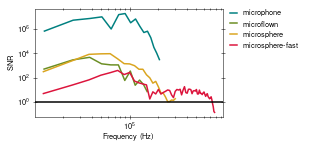

In [244]:
fig, ax = plt.subplots(1, 1, figsize=(3.375, 2))
ax.loglog(ph_freq[1:], ph_psd[1:]/ph0_psd[1:], c=ph_color, label="microphone")
ax.loglog(fl_freq[1:], fl_psd[1:]/fl0_psd[1:], c=fl_color, label="microflown")
ax.loglog(bd_freq[1:-1], bd_psd[1:-1]/bd0_psd[1:] ,c=bd_color, label="microsphere")
ax.loglog(bdf_freq[1:], bdf_psd[1:]/bdf0_psd[1:] ,c=bdf_color, label="microsphere-fast")
ax.axhline(1, c="k")
ax.set_ylabel("SNR")
ax.set_xlabel("Frequency (Hz)")
plt.legend(handlelength=1, frameon=False, loc="upper left", bbox_to_anchor=(1,1.05))
plt.savefig("figures/pulsed_laser_SNR_compare_cutoff-individual.pdf", bbox_inches="tight", dpi=600)

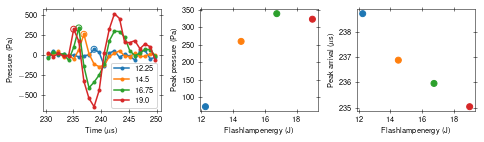

In [236]:
fnames = fnames_ph[1:]
bd_cutoff = 2000e3
fl_cutoff =200e3
tmin= 230e-6
tmax = 250e-6
fig, axs = plt.subplots(1,3, figsize=(3.375*2, 2))
peaks = np.zeros((len(fnames), 2))
enes = np.zeros(len(fnames))
for fnamei, fname in enumerate(fnames):
    Cbd = load_collection(fname, "X", musphere_response_p, 
                      differentiate=True, cutoff=500e3, shift=0, invert=False)
    Cbd.collection[0].plot(ax=axs[0], tmin=tmin, tmax=tmax, unit="Pa", tunit="us", marker=".", label=Cbd.ene)
    
    mask = np.logical_and(Cbd.collection[0].t>tmin, Cbd.collection[0].t<241e-6)
    peakdex = np.argmax(Cbd.collection[0].x[mask])
    peaks[fnamei] = [Cbd.agg.t[mask][peakdex], Cbd.collection[0].x[mask][peakdex]]
    enes[fnamei] = Cbd.ene
    axs[0].scatter(peaks[fnamei][0]*1e6, peaks[fnamei][1], fc="none", ec=f"C{fnamei}")
    #Cfl.collection[20].plot(ax=ax, tmin=tmin, tmax=tmax, unit="Pa", tunit="us")
axs[0].legend()
axs[1].scatter(enes, peaks[:, 1], marker="o", c=[f"C{i}" for i in range(len(fnames))])
axs[2].scatter(enes, peaks[:, 0]*1e6, marker="o", c=[f"C{i}" for i in range(len(fnames))])
axs[0].set_ylabel("Pressure (Pa)")
axs[0].set_xlabel(r"Time (${\rm \mu s}$)")
axs[1].set_ylabel("Peak pressure (Pa)")
axs[1].set_xlabel("Flashlamp energy (J)")
axs[2].set_ylabel(r"Peak arrival (${\rm \mu s}$)")
axs[2].set_xlabel("Flashlamp energy (J)")
plt.tight_layout()
#plt.savefig(f"figures/pulsed_laser_ene-scan.png", dpi=600)